In [175]:
import pandas as pd

df_competitive_1 = pd.read_csv('../results/Competitive_1/Competitive_1_rewards_log.csv')
df_competitive_by_phase = pd.read_csv('../results/CompetitiveByPhase/CompetitiveByPhase_rewards_log.csv')
df_graph = pd.read_csv('../results/Graph/Graph_rewards_log.csv')

print('Competitive_1:', df_competitive_1.shape)
print('CompetitiveByPhase:', df_competitive_by_phase.shape)
print('Graph:', df_graph.shape)

Competitive_1: (34419, 13)
CompetitiveByPhase: (94052, 13)
Graph: (264598, 13)


In [176]:
# Transformación de los dataframes según las instrucciones, eliminando el último episodio (outlier)
# y simplificando posiciones. Versión sin warnings de pandas (evita groupby.apply).

def transformar_df(df):
    columnas = [
        'unix_time', 'episode', 'area_id',
        'collectible_allowed_id', 'reward_amount',
        'agent_pos_x', 'agent_pos_z', 'agent_id'
    ]
    df_filtrado = df.loc[df['agent_id'] == 1, columnas].copy()

    # Eliminar el último episodio
    if not df_filtrado.empty:
        max_episode = df_filtrado['episode'].max()
        df_filtrado = df_filtrado[df_filtrado['episode'] != max_episode]

    # Modificación: restar 136 a x_sign cuando area_id >= 8
    # para compensar la diferencia de posición de las áreas
    df_filtrado.loc[df_filtrado['area_id'] >= 8, 'agent_pos_x'] -= 136

    # Columnas de signo para las posiciones (más barato con boolean -> int8)
    df_filtrado['x_sign'] = (df_filtrado['agent_pos_x'] >= 0).astype('int8')
    df_filtrado['z_sign'] = (df_filtrado['agent_pos_z'] >= 0).astype('int8')
    df_filtrado = df_filtrado.drop(['agent_pos_x', 'agent_pos_z', 'agent_id'], axis=1)

    # Orden estable
    df_filtrado = df_filtrado.sort_values(
        ['episode', 'area_id', 'unix_time'],
        ascending=[True, True, True]
    ).reset_index(drop=True)

    # Clave de grupo legible; luego, si quieres, la comprimimos a codes
    df_filtrado['episode_area_key'] = (
        df_filtrado['episode'].astype(str) + '_' + df_filtrado['area_id'].astype(str)
    )

    # room_change por grupo: 1 si x_sign o z_sign cambian dentro del grupo
    room_change_series = (
        df_filtrado
        .groupby('episode_area_key')[['x_sign', 'z_sign']]
        .nunique()
        .gt(1)               # True si hay >1 valor distinto
        .any(axis=1)         # True si cambia x o z
        .astype('int8')      # 0/1 compacto
    )

    # Mapear al dataframe fila a fila
    df_filtrado['room_change'] = df_filtrado['episode_area_key'].map(room_change_series).astype('int8')

    # Si quieres conservar un id numérico compacto:
    df_filtrado['episode_area_id'] = (
        df_filtrado['episode_area_key'].astype('category').cat.codes.astype('int32')
    )
    df_filtrado = df_filtrado.drop(columns=['episode_area_key'])

    return df_filtrado

# Uso:
df_competitive_1_t = transformar_df(df_competitive_1)
df_competitive_by_phase_t = transformar_df(df_competitive_by_phase)
df_graph_t = transformar_df(df_graph)

print('Competitive_1 transformado:', df_competitive_1_t.shape)
print('CompetitiveByPhase transformado:', df_competitive_by_phase_t.shape)
print('Graph transformado:', df_graph_t.shape)


Competitive_1 transformado: (8666, 9)
CompetitiveByPhase transformado: (93988, 9)
Graph transformado: (264119, 9)


In [177]:
# Muestra de los primeros registros de los dataframes transformados
print('Competitive_1:')
display(df_competitive_1_t.head())
print('CompetitiveByPhase:')
display(df_competitive_by_phase_t.head())
print('Graph:')
display(df_graph_t.head())

Competitive_1:


,unix_time,episode,area_id,collectible_allowed_id,reward_amount,x_sign,z_sign,room_change,episode_area_id
0,1.755480e+09,1,0,1,4,1,1,0,528
1,1.755480e+09,1,0,0,1,1,1,0,528
2,1.755480e+09,1,1,0,1,1,1,0,529
3,1.755480e+09,1,1,0,1,1,1,0,529
4,1.755480e+09,1,1,0,1,1,1,0,529


CompetitiveByPhase:


,unix_time,episode,area_id,collectible_allowed_id,reward_amount,x_sign,z_sign,room_change,episode_area_id
0,1.755559e+09,1,0,1,4,1,1,0,1730
1,1.755560e+09,1,1,0,1,1,1,0,1731
2,1.755559e+09,1,2,1,4,0,1,0,1738
3,1.755559e+09,1,3,0,1,1,0,0,1739
4,1.755560e+09,1,3,0,1,1,0,0,1739


Graph:


,unix_time,episode,area_id,collectible_allowed_id,reward_amount,x_sign,z_sign,room_change,episode_area_id
0,1.755753e+09,1,0,0,-2,0,1,0,1760
1,1.755753e+09,1,0,0,-2,0,1,0,1760
2,1.755753e+09,1,0,0,-2,0,1,0,1760
3,1.755753e+09,1,0,0,-2,0,1,0,1760
4,1.755753e+09,1,0,1,4,0,1,0,1760


In [178]:
# Segunda transformación: pivotear los valores de reward_amount en columnas de recuento, incluyendo reward_+ para positivos
def transformar_recuento_reward(df):
    # Eliminar columnas no deseadas
    df_simple = df.drop(['unix_time', 'x_sign', 'z_sign', 'collectible_allowed_id', 'reward_amount'], axis=1)
    # Crear tabla de recuentos por combinaciones únicas
    counts = pd.crosstab([df['episode_area_id'], df['episode'], df['area_id']], df['reward_amount'])
    counts.columns = [f'reward_{col}' for col in counts.columns]
    counts = counts.reset_index()
    # Calcular reward_+ (recuento de rewards positivos)
    positivos = df[df['reward_amount'] > 0].groupby(['episode_area_id', 'episode', 'area_id'])['reward_amount'].count().reset_index(name='reward_+')
    # Unir reward_+ a counts
    counts = pd.merge(counts, positivos, on=['episode_area_id', 'episode', 'area_id'], how='left')
    counts['reward_+'] = counts['reward_+'].fillna(0).astype(int)
    # Unir con el dataframe simple por las claves únicas
    df_final = pd.merge(df_simple.drop_duplicates(['episode_area_id', 'episode', 'area_id']), counts, on=['episode_area_id', 'episode', 'area_id'], how='left')
    return df_final

In [179]:
# Mostrar una muestra de los tres dataframes transformados con recuento de reward_amount
df_competitive_1_counts = transformar_recuento_reward(df_competitive_1_t)
df_competitive_by_phase_counts = transformar_recuento_reward(df_competitive_by_phase_t)
df_graph_counts = transformar_recuento_reward(df_graph_t)

print('Competitive_1:')
display(df_competitive_1_counts.head())

print('CompetitiveByPhase:')
display(df_competitive_by_phase_counts.head())

print('Graph:')
display(df_graph_counts.head())

Competitive_1:


,episode,area_id,room_change,episode_area_id,reward_1,reward_4,reward_+
0,1,0,0,528,1,1,2
1,1,1,0,529,5,0,5
2,1,2,0,536,1,1,2
3,1,3,0,537,2,0,2
4,1,4,0,538,3,2,5


CompetitiveByPhase:


,episode,area_id,room_change,episode_area_id,reward_1,reward_4,reward_+
0,1,0,0,1730,0,1,1
1,1,1,0,1731,1,0,1
2,1,2,0,1738,0,1,1
3,1,3,0,1739,2,0,2
4,1,4,0,1740,0,1,1


Graph:


,episode,area_id,room_change,episode_area_id,reward_-2,reward_4,reward_5,reward_+
0,1,0,0,1760,11,2,0,2
1,1,1,0,1761,5,2,0,2
2,1,2,0,1768,5,2,0,2
3,1,3,0,1769,6,3,0,3
4,1,4,0,1770,9,0,2,2


In [180]:
# Colores estándar para los experimentos
COLOR_COMPETITIVE_1 = '#1f77b4'  # Azul
COLOR_COMPETITIVE_BY_PHASE = '#ff7f0e'  # Naranja
COLOR_GRAPH = '#2ca02c'  # Verde

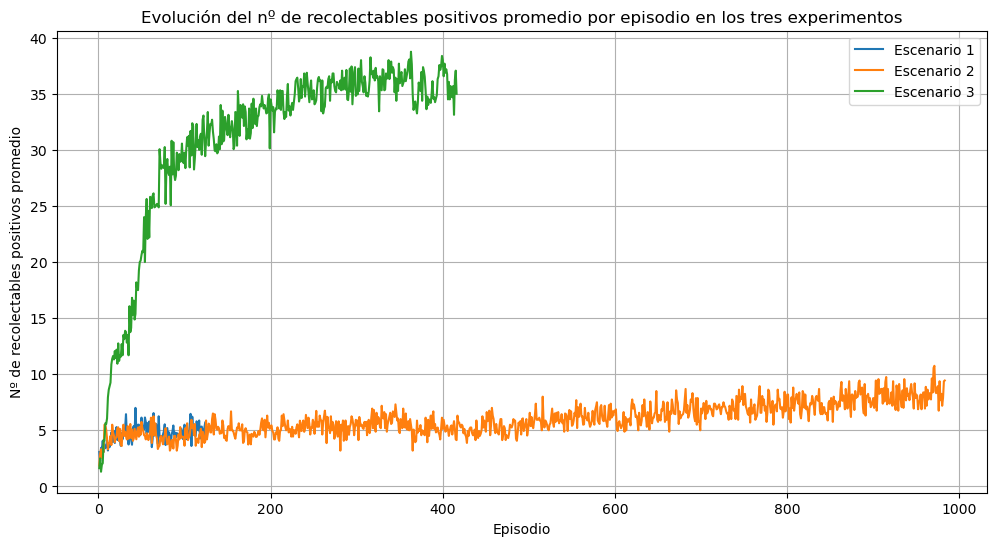

In [181]:
plt.figure(figsize=(12,6))
plt.plot(df_competitive_1_counts.groupby('episode')['reward_+'].mean(), label='Escenario 1')
plt.plot(df_competitive_by_phase_counts.groupby('episode')['reward_+'].mean(), label='Escenario 2')
plt.plot(df_graph_counts.groupby('episode')['reward_+'].mean(), label='Escenario 3')
plt.xlabel('Episodio')
plt.ylabel('Nº de recolectables positivos promedio')
plt.title('Evolución del nº de recolectables positivos promedio por episodio en los tres experimentos')
plt.legend()
plt.grid(True)
plt.show()

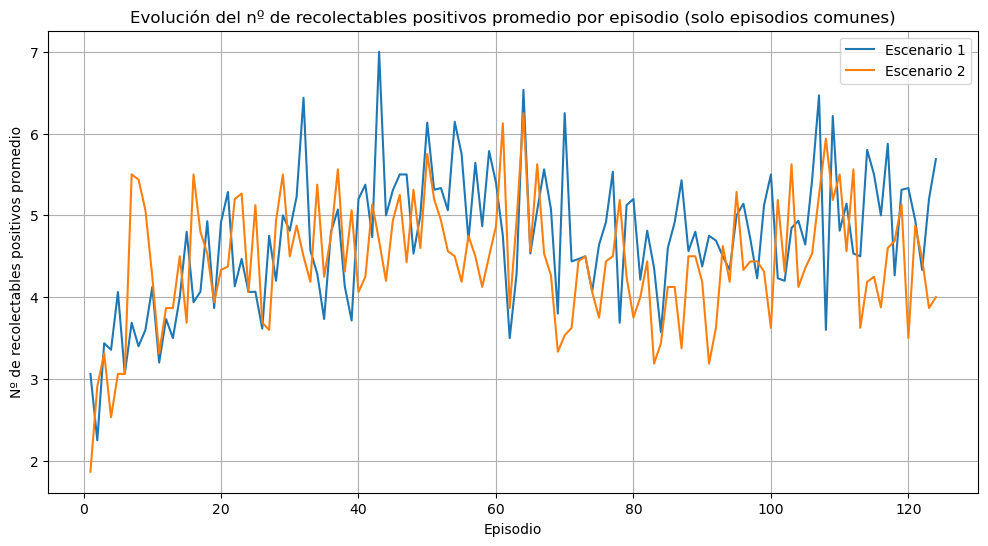

In [182]:
# Graficar solo episodios donde ambas tablas tienen datos
mean_1 = df_competitive_1_counts.groupby('episode')['reward_+'].mean()
mean_2 = df_competitive_by_phase_counts.groupby('episode')['reward_+'].mean()
common_episodes = mean_1.index.intersection(mean_2.index)

plt.figure(figsize=(12,6))
plt.plot(common_episodes, mean_1.loc[common_episodes], label='Escenario 1', color=COLOR_COMPETITIVE_1)
plt.plot(common_episodes, mean_2.loc[common_episodes], label='Escenario 2', color=COLOR_COMPETITIVE_BY_PHASE)
plt.xlabel('Episodio')
plt.ylabel('Nº de recolectables positivos promedio')
plt.title('Evolución del nº de recolectables positivos promedio por episodio (solo episodios comunes)')
plt.legend()
plt.grid(True)
plt.show()

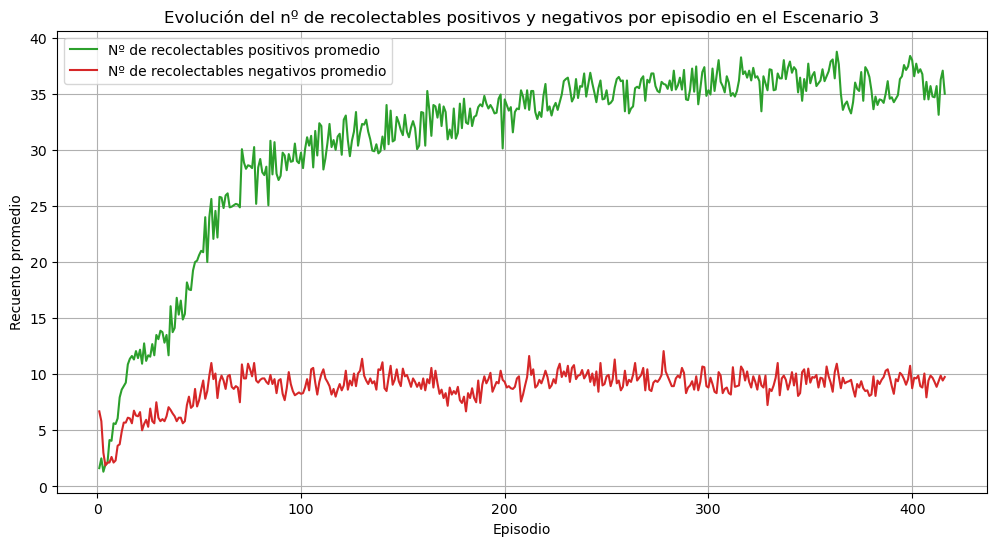

In [183]:
# Gráfica de evolución de reward_+ y reward_- (reward_-2) por episodio en df_graph_counts
plt.figure(figsize=(12,6))
plt.plot(df_graph_counts.groupby('episode')['reward_+'].mean(), label='Nº de recolectables positivos promedio', color=COLOR_GRAPH)
plt.plot(df_graph_counts.groupby('episode')['reward_-2'].mean(), label='Nº de recolectables negativos promedio', color='#d62728')
plt.xlabel('Episodio')
plt.ylabel('Recuento promedio')
plt.title('Evolución del nº de recolectables positivos y negativos por episodio en el Escenario 3')
plt.legend()
plt.grid(True)
plt.show()

In [184]:
import pandas as pd

def resumen_room_change(df):
    base = (
        df[['episode_area_id', 'episode', 'area_id']]
        .drop_duplicates(subset=['episode_area_id'])
    )

    room_change_sum = (
        df.groupby('episode_area_id', as_index=False)['room_change']
          .sum()
          .rename(columns={'room_change': 'room_change_sum'})
    )

    # Crear una clave combinada como string y contar únicos
    combos = (
        df.assign(xz_pair=df['x_sign'].astype(str) + "_" + df['z_sign'].astype(str))
          .groupby('episode_area_id', as_index=False)['xz_pair']
          .nunique()
          .rename(columns={'xz_pair': 'distinct_xz_combinations'})
    )

    resumen = (
        base.merge(room_change_sum, on='episode_area_id', how='left')
            .merge(combos, on='episode_area_id', how='left')
            .sort_values(['episode', 'area_id'], ascending=True)
            .reset_index(drop=True)
    )
    return resumen

# Uso
df_competitive_1_room = resumen_room_change(df_competitive_1_t)
df_competitive_by_phase_room = resumen_room_change(df_competitive_by_phase_t)
df_graph_room = resumen_room_change(df_graph_t)

print('Competitive_1:')
display(df_competitive_1_room.head())
print('CompetitiveByPhase:')
display(df_competitive_by_phase_room.head())
print('Graph:')
display(df_graph_room.head())


Competitive_1:


,episode_area_id,episode,area_id,room_change_sum,distinct_xz_combinations
0,528,1,0,0,1
1,529,1,1,0,1
2,536,1,2,0,1
3,537,1,3,0,1
4,538,1,4,0,1


CompetitiveByPhase:


,episode_area_id,episode,area_id,room_change_sum,distinct_xz_combinations
0,1730,1,0,0,1
1,1731,1,1,0,1
2,1738,1,2,0,1
3,1739,1,3,0,1
4,1740,1,4,0,1


Graph:


,episode_area_id,episode,area_id,room_change_sum,distinct_xz_combinations
0,1760,1,0,0,1
1,1761,1,1,0,1
2,1768,1,2,0,1
3,1769,1,3,0,1
4,1770,1,4,0,1


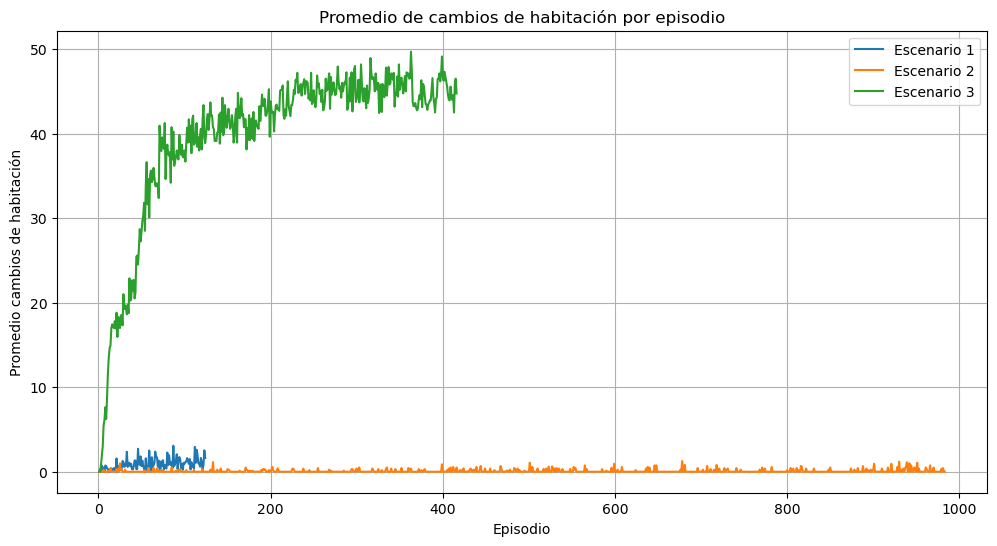

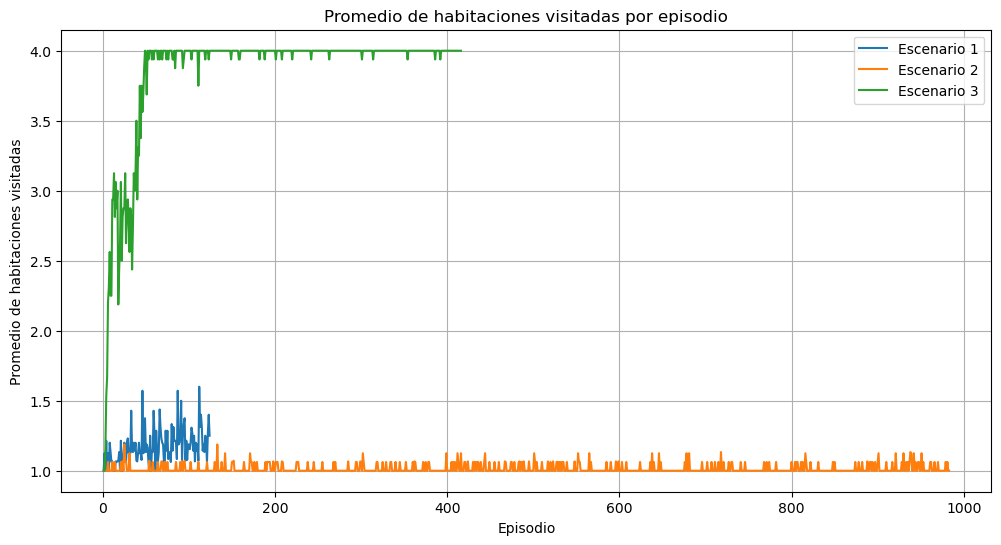

In [185]:
plt.figure(figsize=(12,6))
plt.plot(df_competitive_1_room.groupby('episode')['room_change_sum'].mean(), label='Escenario 1', color=COLOR_COMPETITIVE_1)
plt.plot(df_competitive_by_phase_room.groupby('episode')['room_change_sum'].mean(), label='Escenario 2', color=COLOR_COMPETITIVE_BY_PHASE)
plt.plot(df_graph_room.groupby('episode')['room_change_sum'].mean(), label='Escenario 3', color=COLOR_GRAPH)
plt.xlabel('Episodio')
plt.ylabel('Promedio cambios de habitación')
plt.title('Promedio de cambios de habitación por episodio')
plt.legend()
plt.grid(True)
plt.show()

plt.figure(figsize=(12,6))
plt.plot(df_competitive_1_room.groupby('episode')['distinct_xz_combinations'].mean(), label='Escenario 1', color=COLOR_COMPETITIVE_1)
plt.plot(df_competitive_by_phase_room.groupby('episode')['distinct_xz_combinations'].mean(), label='Escenario 2', color=COLOR_COMPETITIVE_BY_PHASE)
plt.plot(df_graph_room.groupby('episode')['distinct_xz_combinations'].mean(), label='Escenario 3', color=COLOR_GRAPH)
plt.xlabel('Episodio')
plt.ylabel('Promedio de habitaciones visitadas')
plt.title('Promedio de habitaciones visitadas por episodio')
plt.legend()
plt.grid(True)
plt.show()

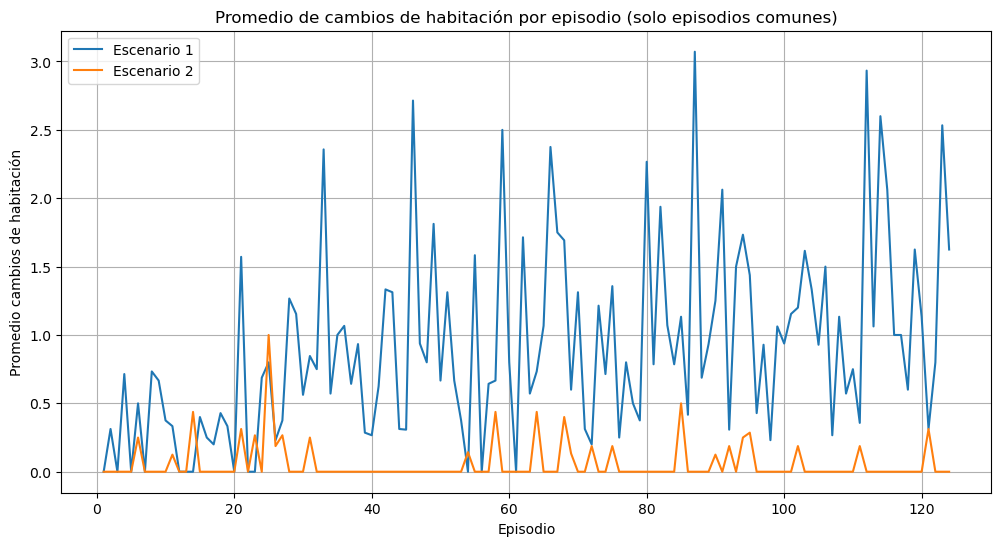

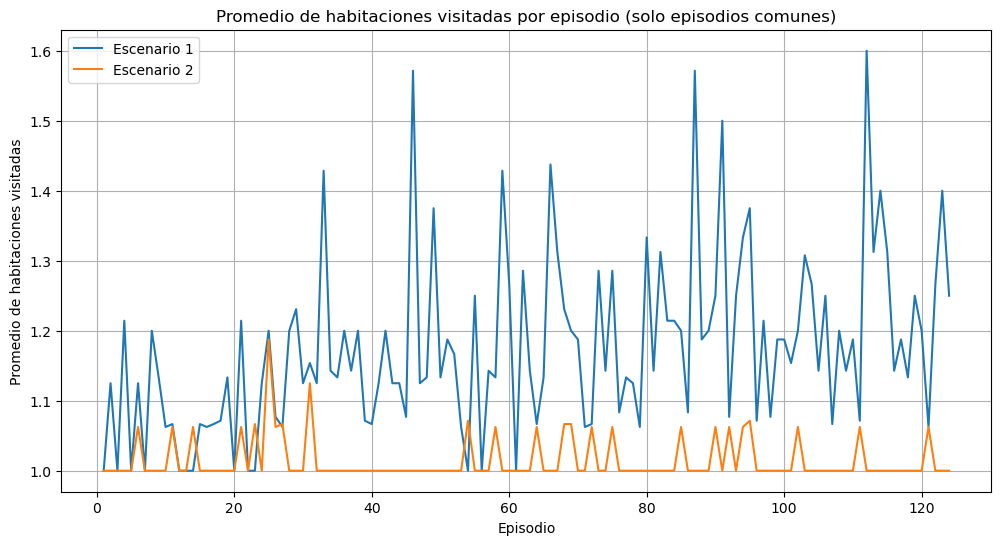

In [186]:
# Graficar solo episodios donde ambas tablas tienen datos para room_change_sum y distinct_xz_combinations
mean_room_1 = df_competitive_1_room.groupby('episode')['room_change_sum'].mean()
mean_room_2 = df_competitive_by_phase_room.groupby('episode')['room_change_sum'].mean()
common_episodes_room = mean_room_1.index.intersection(mean_room_2.index)

plt.figure(figsize=(12,6))
plt.plot(common_episodes_room, mean_room_1.loc[common_episodes_room], label='Escenario 1', color=COLOR_COMPETITIVE_1)
plt.plot(common_episodes_room, mean_room_2.loc[common_episodes_room], label='Escenario 2', color=COLOR_COMPETITIVE_BY_PHASE)
plt.xlabel('Episodio')
plt.ylabel('Promedio cambios de habitación')
plt.title('Promedio de cambios de habitación por episodio (solo episodios comunes)')
plt.legend()
plt.grid(True)
plt.show()

mean_xz_1 = df_competitive_1_room.groupby('episode')['distinct_xz_combinations'].mean()
mean_xz_2 = df_competitive_by_phase_room.groupby('episode')['distinct_xz_combinations'].mean()
common_episodes_xz = mean_xz_1.index.intersection(mean_xz_2.index)

plt.figure(figsize=(12,6))
plt.plot(common_episodes_xz, mean_xz_1.loc[common_episodes_xz], label='Escenario 1', color=COLOR_COMPETITIVE_1)
plt.plot(common_episodes_xz, mean_xz_2.loc[common_episodes_xz], label='Escenario 2', color=COLOR_COMPETITIVE_BY_PHASE)
plt.xlabel('Episodio')
plt.ylabel('Promedio de habitaciones visitadas')
plt.title('Promedio de habitaciones visitadas por episodio (solo episodios comunes)')
plt.legend()
plt.grid(True)
plt.show()

In [222]:
# Convertir SVG a PNG y exportar
import cairosvg

svg_files = [
    'Environment_Cumulative Reward 1.svg',
    'Environment_Cumulative Reward 2.svg',
    'Environment_Cumulative Reward 3.svg',
    'logo.svg'
]

for svg_file in svg_files:
    png_file = svg_file.replace('.svg', '.png')
    # Exporta el logo con más resolución
    if svg_file == 'logo.svg':
        cairosvg.svg2png(url=svg_file, write_to=png_file, output_width=1200)
    else:
        cairosvg.svg2png(url=svg_file, write_to=png_file)
    print(f'Exportado: {png_file}')

Exportado: Environment_Cumulative Reward 1.png
Exportado: Environment_Cumulative Reward 2.png
Exportado: Environment_Cumulative Reward 3.png
Exportado: logo.png


In [228]:
import pypandoc
import os

# Directorio donde están los archivos .md
md_dir = '../memory'
md_files = [
    '1_introduccion.md',
    '2_metodologia.md',
    '3_resultados.md',
    '4_conclusiones.md'
]

# Diccionario de reemplazos Unicode -> LaTeX
unicode_to_latex = {
    'ε': r'$\epsilon$',
    'λ': r'$\lambda$',
    'γ': r'$\gamma$',
    'β': r'$\beta$',
    '≈': r'$\approx$',
    '↔': r'$\leftrightarrow$'
}

def replace_unicode_latex(text):
    for uni, latex in unicode_to_latex.items():
        # Añade espacio antes y después si está pegado a texto o números
        text = text.replace(uni, f' {latex} ')
    return text

# Ruta completa de los archivos
md_paths = [os.path.join(md_dir, f) for f in md_files]

# Unir los archivos en uno solo, reemplazando símbolos problemáticos
with open('memoria_unificada.md', 'w', encoding='utf-8') as outfile:
    for fname in md_paths:
        with open(fname, 'r', encoding='utf-8') as infile:
            content = infile.read()
            content = replace_unicode_latex(content)
            outfile.write(content)
            outfile.write('\n\n')  # Separador entre archivos

# Convertir el markdown unificado a PDF usando XeLaTeX
output_pdf = 'memoria_TFM.pdf'
pypandoc.convert_file(
    'memoria_unificada.md',
    'pdf',
    outputfile=output_pdf,
    extra_args=[
        '--pdf-engine=xelatex',
        '--include-in-header=header.tex',
        '--citeproc',
        '--metadata-file=metadata.yaml',
        '--metadata=bibliography-title=Referencias',
        '--bibliography=references.bib',
        '--metadata=link-citations=true',
        '--metadata=link-bibliography=true',
        '--csl=data-science-and-engineering.csl',
        '--template=eisvogel.latex',
    ]
)

''